<IPython.core.display.Javascript object>


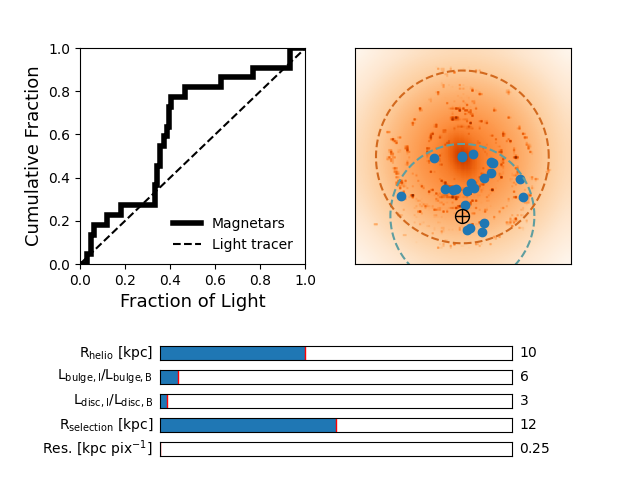

0

In [1]:
"""
@author: Ashley Chrimes
Interactive Milky Way fraction of light tool for Galactic neutron star populations
See Chrimes et al. (2021) for details
"""

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage
from matplotlib import colors
from matplotlib import cm
from matplotlib.widgets import Slider

# Olausen et al. 2014 McGill catalogue data (http://www.physics.mcgill.ca/~pulsar/magnetar/main.html)
MWmagnetars = pd.read_csv('TabO1.csv')       
distances = MWmagnetars.Dist.values


#-------------------------------------------------------------------------------------------------------------#
############### FRACTIONAL LIGHT #########################################################
#-------------------------------------------------------------------------------------------------------------#
fig = plt.figure()
plt.subplots_adjust(bottom=0.45,top=0.9)
ax1 = fig.add_subplot(121)
p = ax1.plot([-1,-2],[0,1])

# Setting up widgets
ax_slide = plt.axes([0.25, 0.1, 0.55, 0.03]) 
s_factor = Slider(ax_slide, 'R$_\mathrm{selection}$ [kpc]', 0.3*30, 0.5*30, valinit=0.4*30, valstep=0.01*30)

ax_slide2 = plt.axes([0.25, 0.05, 0.55, 0.03])
s_factor2 = Slider(ax_slide2, 'Res. [kpc pix$^{-1}$]', 30/120, 30/15, valinit=30/120, valstep=0.05)

ax_slide3 = plt.axes([0.25, 0.15, 0.55, 0.03])
s_factor3 = Slider(ax_slide3, 'L$_\mathrm{disc,I}$/L$_\mathrm{disc,B}$', 1, 100, valinit=3, valstep=1)

ax_slide4 = plt.axes([0.25, 0.2, 0.55, 0.03])
s_factor4 = Slider(ax_slide4, 'L$_\mathrm{bulge,I}$/L$_\mathrm{bulge,B}$', 1, 100, valinit=6, valstep=1)

ax_slide5 = plt.axes([0.25, 0.25, 0.55, 0.03])
s_factor5 = Slider(ax_slide5, 'R$_\mathrm{helio}$ [kpc]', 3, 20, valinit=10, valstep=1)



# Creating the interactive figure with default slider values
maxdistlim = s_factor5.val #kpc
names = MWmagnetars.Name.values[(distances > 0) & (distances < maxdistlim)]
xmag = np.loadtxt('mcgill_x.txt')[(distances > 0) & (distances < maxdistlim)]
ymag = np.loadtxt('mcgill_y.txt')[(distances > 0) & (distances < maxdistlim)]   
hmag = np.loadtxt('mcgill_h.txt')[(distances > 0) & (distances < maxdistlim)]   
derrup = MWmagnetars.Dist_EUp.values[(distances > 0) & (distances < maxdistlim)]
derrlo = MWmagnetars.Dist_EDn.values[(distances > 0) & (distances < maxdistlim)]
dmag = distances[(distances > 0) & (distances < maxdistlim)]

# Radius within which to select pixels for Flight, and the image resolution
circlecut = s_factor.val/30
Res = int(30/(s_factor2.val) - 1) 
R = 30/(Res+1)

# Factor by which to reduce the pixel values of the components
armdisc_redux = s_factor3.val
bulgebar_redux = s_factor4.val

# Loading the component images with the chosen resolution and flux scaling 
# These were created with the Urquhart et al. 2014 masers and the method of Reid et al. 2019
# For details of this and the other components, see Chrimes et al. (2021)
arms = np.loadtxt('Fullmap/Arms_'+str(Res)+'.txt')/(armdisc_redux)
disc_in = np.loadtxt('Fullmap/Disc_'+str(Res)+'.txt')/(armdisc_redux)
disc = scipy.ndimage.gaussian_filter(disc_in,sigma=5)
barbulge = np.loadtxt('Fullmap/Barbulge_'+str(Res)+'.txt')/(bulgebar_redux)

# The image
Resgrid = arms + disc + barbulge

# Creating the image
ax2 = fig.add_subplot(122)
ax2.imshow(Resgrid,cmap=cm.Oranges,norm=colors.LogNorm()) 
ax2.invert_yaxis()
ax2.set_yticks([])
ax2.set_xticks([])

theta = np.linspace(0, 2*np.pi, 100)
rhelio = maxdistlim*((Res+1)/30)
XC = rhelio*np.cos(theta) + (0/R + Res/2)
YC = rhelio*np.sin(theta) + ((0-8.2)/R + Res/2)
ax2.plot(XC,YC,color='cadetblue',linestyle='--')

rselection = s_factor.val*((Res+1)/30)
XS = rselection*np.cos(theta) + (0/R + Res/2)
YS = rselection*np.sin(theta) + ((8.2-8.2)/R + Res/2)
ax2.plot(XS,YS,color='chocolate',linestyle='--')

ax2.set_xlim([0,Res+1])
ax2.set_ylim([0,Res+1])

# Fraction of light calculation begins
shiftedx = (xmag[1:21]/R + Res/2)
shiftedy = ((ymag[1:21]-8.2)/R + Res/2)
ax2.scatter(shiftedx,shiftedy)
ax2.plot((0/R + Res/2),((0-8.2)/R + Res/2),'ok',fillstyle='none',markersize=10)
ax2.plot((0/R + Res/2),((0-8.2)/R + Res/2),'+k',markersize=10)

# Geting all pixel values and sorting them into increasing order.
zlist = []
rlist = []
indicies = []
II = 0
mask = np.ones((Res+1,Res+1))    
indexes = np.linspace(0,Res,Res+1).astype(int)
for valx in indexes:
    for valy in indexes:   
        zlist = zlist + [Resgrid[valy,valx]]   
        rval = np.sqrt((valx-(Res+1)/2)**2 + (valy-(Res+1)/2)**2)
        rlist = rlist + [rval] #radial distance from centre of image
        indicies.append(II)
        if rval < circlecut*(Res+1):  
            mask[valy,valx] = np.nan
        II = II + 1
zlist = np.array(zlist)
rlist = np.array(rlist)
indicies = np.array(indicies)

indicies = indicies[rlist < circlecut*(Res+1)]    # selecting the pixel indicies that satisify circlecut
zlist = zlist[rlist < circlecut*(Res+1)]   
zsort, indexsort = zip(*sorted(zip(zlist,indicies)))    #indicies sorted by z value

zsort = np.array(zsort)
flcumul = []
cflux = 0
for entry in zsort:
    cflux = cflux + entry
    flcumul.append(cflux)
flight_masers = np.array(flcumul)/np.max(flcumul)  #every pixel gets assigned a value from 0 to 1

# Ordering x,y PIXEL coordinates so that each z value has a coordinate pair in the same order as z and the indicies
xlist = []
ylist = []
c = 0
for Xx in indexes:
    for Yy in indexes:   
        if c in indicies:  
            xlist.append(Xx)
            ylist.append(Yy)  
        c = c + 1
zsort, xsort = zip(*sorted(zip(zlist, xlist))) 
zsort, ysort = zip(*sorted(zip(zlist, ylist))) 
#x and y are now ordered the same as z (increasing z) and indexsort.
xsort = np.array(xsort)
ysort = np.array(ysort)


# Flight for the magnetars, which image pixels do they land on / what are the Flight values?
mgn = 0
bestdex = []
offthehost = []
for XM in shiftedx:
       diffx = (XM - (xsort))**2
       diffy = (shiftedy[mgn] - (ysort))**2   #'shifted' includes R/2 to shift coordinates to CENTER of the pixel
       dist = np.sqrt(diffx+diffy)
       gradshifted = np.sqrt( (XM - (Res+1)/2)**2 + (shiftedy[mgn] - (Res+1)/2)**2 )
       if gradshifted >= circlecut*(Res+1):  #outside the host? then use Flight = 0
           offthehost.append(mgn)
       bestdex.append(np.where(dist == np.min(dist))[0][0])  #indicies of the cells which are closest
       mgn = mgn + 1
magnetar_flight = flight_masers[bestdex]  
magnetar_flight[offthehost] = 0

# Plotting Flight
N,bins,patches = ax1.hist(magnetar_flight,histtype='step',density=True,cumulative=True,bins=np.linspace(0,1,100),linewidth=4,color='k')
patches[0].set_xy(patches[0].get_xy()[:-1])
p, = ax1.plot([0,1],[-1,-2],'-k',linewidth=4,label='Magnetars')
ax1.set_xlabel('Fraction of Light',fontsize=12)
ax1.set_ylabel('Cumulative Fraction',fontsize=12)
p, = ax1.plot([0,1],[0,1],'--k',label='Light tracer')
ax1.legend(loc=4,frameon=False)
ax1.set(xlim=(0,1), ylim=(0,1))



# Same as above, but with update-able parameters based on user defined slider values
def update(val):
    ax1.clear()
    ax2.clear()
    
    maxdistlim = s_factor5.val #kpc
    distances = MWmagnetars.Dist.values
    names = MWmagnetars.Name.values[(distances > 0) & (distances < maxdistlim)]
    xmag = np.loadtxt('mcgill_x.txt')[(distances > 0) & (distances < maxdistlim)]
    ymag = np.loadtxt('mcgill_y.txt')[(distances > 0) & (distances < maxdistlim)]   
    hmag = np.loadtxt('mcgill_h.txt')[(distances > 0) & (distances < maxdistlim)]   
    derrup = MWmagnetars.Dist_EUp.values[(distances > 0) & (distances < maxdistlim)]
    derrlo = MWmagnetars.Dist_EDn.values[(distances > 0) & (distances < maxdistlim)]
    dmag = distances[(distances > 0) & (distances < maxdistlim)]

    circlecut = s_factor.val/30
    Resin = 30/(s_factor2.val) - 1
    Reslist = np.array([14,29,59,89,119])
    Diff = np.ndarray.tolist(np.abs(Resin-Reslist))
    mindex = Diff.index(np.min(Diff))
    Res = int(Reslist[mindex])

    armdisc_redux = s_factor3.val
    bulgebar_redux = s_factor4.val
    
    arms = np.loadtxt('Fullmap/Arms_'+str(Res)+'.txt')/(armdisc_redux)
    disc_in = np.loadtxt('Fullmap/Disc_'+str(Res)+'.txt')/(armdisc_redux)
    disc = scipy.ndimage.gaussian_filter(disc_in,sigma=5)
    barbulge = np.loadtxt('Fullmap/Barbulge_'+str(Res)+'.txt')/(bulgebar_redux)
    
    Resgrid = arms + disc + barbulge
    
    R = 30/(Res+1)

    ax2.imshow(Resgrid,cmap=cm.Oranges,norm=colors.LogNorm()) 
    ax2.invert_yaxis()
    ax2.set_yticks([])
    ax2.set_xticks([])

    rhelio = maxdistlim*((Res+1)/30)
    XC = rhelio*np.cos(theta) + (0/R + Res/2)
    YC = rhelio*np.sin(theta) + ((0-8.2)/R + Res/2)
    ax2.plot(XC,YC,color='cadetblue',linestyle='--')
    
    rselection = s_factor.val*((Res+1)/30)
    XS = rselection*np.cos(theta) + (0/R + Res/2)
    YS = rselection*np.sin(theta) + ((8.2-8.2)/R + Res/2)
    ax2.plot(XS,YS,color='chocolate',linestyle='--')
    ax2.set_xlim([0,Res+1])
    ax2.set_ylim([0,Res+1])
    
    shiftedx = (xmag/R + Res/2)
    shiftedy = ((ymag-8.2)/R + Res/2)
    ax2.scatter(shiftedx,shiftedy)
    ax2.plot((0/R + Res/2),((0-8.2)/R + Res/2),'ok',fillstyle='none',markersize=10)
    ax2.plot((0/R + Res/2),((0-8.2)/R + Res/2),'+k',markersize=10)
    
    zlist = []
    rlist = []
    indicies = []
    II = 0
    mask = np.ones((Res+1,Res+1))      
    indexes = np.linspace(0,Res,Res+1).astype(int)
    for valx in indexes:
        for valy in indexes:  
            zlist = zlist + [Resgrid[valy,valx]]  
            #plt.plot(valx,valy,'.c')    #
            rval = np.sqrt((valx-(Res+1)/2)**2 + (valy-(Res+1)/2)**2)
            rlist = rlist + [rval]
            indicies.append(II)
            if rval < circlecut*(Res+1):   
                mask[valy,valx] = np.nan
            II = II + 1
    zlist = np.array(zlist)
    rlist = np.array(rlist)
    indicies = np.array(indicies)
    
    indicies = indicies[rlist < circlecut*(Res+1)]   
    zlist = zlist[rlist < circlecut*(Res+1)]  
    zsort, indexsort = zip(*sorted(zip(zlist,indicies)))  
    
    zsort = np.array(zsort)
    flcumul = []
    cflux = 0
    for entry in zsort:
        cflux = cflux + entry
        flcumul.append(cflux)
    flight_masers = np.array(flcumul)/np.max(flcumul) 
    
    xlist = []
    ylist = []
    c = 0
    for Xx in indexes:
        for Yy in indexes:    
            if c in indicies:  
                xlist.append(Xx)
                ylist.append(Yy)  
            c = c + 1
    zsort, xsort = zip(*sorted(zip(zlist, xlist))) 
    zsort, ysort = zip(*sorted(zip(zlist, ylist))) 

    xsort = np.array(xsort)
    ysort = np.array(ysort)
    
    mgn = 0
    bestdex = []
    offthehost = []
    for XM in shiftedx:
           diffx = (XM - (xsort))**2
           diffy = (shiftedy[mgn] - (ysort))**2   
           dist = np.sqrt(diffx+diffy)
           gradshifted = np.sqrt( (XM - (Res+1)/2)**2 + (shiftedy[mgn] - (Res+1)/2)**2 )
           if gradshifted >= circlecut*(Res+1):  
               offthehost.append(mgn)
           bestdex.append(np.where(dist == np.min(dist))[0][0]) 
           mgn = mgn + 1
    magnetar_flight = flight_masers[bestdex]  
    magnetar_flight[offthehost] = 0
    
    N,bins,patches = ax1.hist(magnetar_flight,histtype='step',density=True,cumulative=True,bins=np.linspace(0,1,100),linewidth=4,color='k')
    patches[0].set_xy(patches[0].get_xy()[:-1])
    ax1.plot([0,1],[-1,-2],'-k',linewidth=4,label='Magnetars')
    ax1.set_xlabel('Fraction of Light',fontsize=13)
    ax1.set_ylabel('Cumulative Fraction',fontsize=13)
    ax1.plot([0,1],[0,1],'--k',label='Light tracer')
    ax1.legend(loc=4,frameon=False)
    ax1.set(xlim=(0,1), ylim=(0,1))


s_factor.on_changed(update)
s_factor2.on_changed(update)
s_factor3.on_changed(update)
s_factor4.on_changed(update)
s_factor5.on_changed(update)
